In [179]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import kagglehub

In [180]:
np.random.seed(42)

In [181]:
class RegressionOLS:
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.coefficients = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.coefficients)
    

class RegressionTorch:
    def __init__(self):
        self.model = None

    def fit(self, X, y, epochs=1000, lr=0.01):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        n_samples, n_features = X_tensor.shape
        self.model = torch.nn.Linear(n_features, 1)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        self.train(X_tensor, y_tensor, optimizer, criterion, epochs)


    def __str__(self):
        return f'Coefficients: {self.model.weight.data.numpy()}\nIntercept: {self.model.bias.data.numpy()}'


    def get_params(self):
        return (self.model.weight.data.numpy(), self.model.bias.data.numpy())

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):

        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

In [182]:
A = 2.3
b = 4.5
N = 100
epsilon = np.random.normal(0, 0.5, N)
X = np.linspace(0, 1, N)
Y = A  * X + b + epsilon


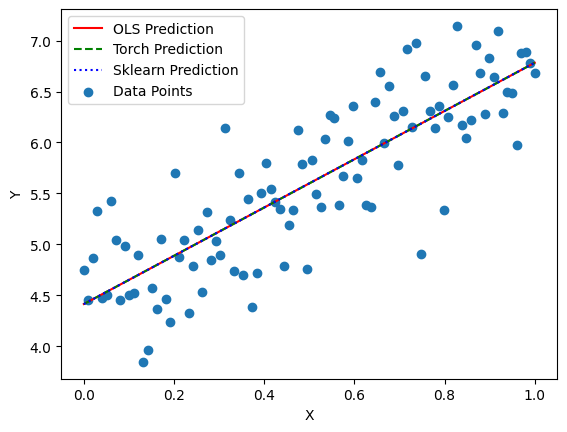

In [183]:
model_ols = RegressionOLS()
model_ols.fit(X.reshape(-1, 1), Y)
Y_pred_ols = model_ols.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_ols, color='red', label='OLS Prediction')

model_torch = RegressionTorch()
model_torch.fit(X.reshape(-1, 1), Y, epochs=2000, lr=0.05)
Y_pred_torch = model_torch.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_torch, color='green', linestyle='--', label='Torch Prediction')

model_sklearn = LinearRegression()
model_sklearn.fit(X.reshape(-1, 1), Y)
Y_pred_sklearn = model_sklearn.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_sklearn, color='blue', linestyle=':', label='Sklearn Prediction')

plt.scatter(X, Y, label='Data Points')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

In [184]:
print("OLS Coefficients:", model_ols.coefficients[::-1])
print("Torch Coefficients:", model_torch.model.weight.data.numpy(), model_torch.model.bias.data.numpy())
print("Sklearn Coefficients:", model_sklearn.coef_, model_sklearn.intercept_)

OLS Coefficients: [2.36896634 4.41359357]
Torch Coefficients: [[2.3689392]] [4.4136095]
Sklearn Coefficients: [2.36896634] 4.413593572961313


In [185]:
import kagglehub
path = kagglehub.dataset_download("prokshitha/home-value-insights")

print("Path to dataset files:", path)


file = 'house_price_regression_dataset.csv'

Path to dataset files: /home/felix/.cache/kagglehub/datasets/prokshitha/home-value-insights/versions/1


In [186]:
df_1 = pd.read_csv(path + '/' + file)


In [187]:
df_1.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [188]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [189]:
df_1['House_Price'].describe()

count    1.000000e+03
mean     6.188610e+05
std      2.535681e+05
min      1.116269e+05
25%      4.016482e+05
50%      6.282673e+05
75%      8.271413e+05
max      1.108237e+06
Name: House_Price, dtype: float64

All ints/floats - we are good to go!

In [190]:
X_train, X_test, y_train, y_test = train_test_split(
    df_1.drop(columns=['House_Price']),
    df_1['House_Price'],
    test_size=0.2,
    random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
model_ols = RegressionOLS()
model_ols.fit(X_train_scaled, y_train)

model_torch = RegressionTorch()
model_torch.fit(X_train_scaled, y_train.values, epochs=1000, lr=0.01)

model_sklearn = LinearRegression()
model_sklearn.fit(X_train_scaled, y_train)


preds = {}

for model, name in zip(
    [model_ols, model_torch, model_sklearn],
    ['OLS', 'Torch', 'Sklearn']
):
    if name == 'OLS':
        y_pred = model.predict(X_test_scaled)
    elif name == 'Torch':
        y_pred = model.predict(X_test_scaled).flatten()
    else:
        y_pred = model.predict(X_test_scaled)


    preds[name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("+-"*40)
    print(f"{name} Model - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}, Avg Percent Error: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
OLS Model - MSE: 101434798.51, RMSE: 10071.48, R2: 1.00, MAE: 8174.58, Avg Percent Error: 1.66%
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Torch Model - MSE: 101435725.29, RMSE: 10071.53, R2: 1.00, MAE: 8174.64, Avg Percent Error: 1.66%
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Sklearn Model - MSE: 101434798.51, RMSE: 10071.48, R2: 1.00, MAE: 8174.58, Avg Percent Error: 1.66%


In [192]:
class LassoRegressionTorch(RegressionTorch):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            mse_loss = criterion(outputs, y_tensor)
            l1_penalty = self.alpha * torch.sum(torch.abs(self.model.weight))
            loss = mse_loss + l1_penalty
            loss.backward()
            optimizer.step()


class RidgeRegressionTorch(RegressionTorch):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            mse_loss = criterion(outputs, y_tensor)
            l2_penalty = self.alpha * torch.sum(self.model.weight ** 2)
            loss = mse_loss + l2_penalty
            loss.backward()
            optimizer.step()

In [193]:
model_torch_lasso = LassoRegressionTorch(alpha=0.1)
model_torch_lasso.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)

model_torch_ridge = RidgeRegressionTorch(alpha=0.1)
model_torch_ridge.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)

model_torch = RegressionTorch()
model_torch.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)



In [194]:
print("Baseline Torch Model Coefficients:")
print(model_torch)

print("Lasso Torch Model Coefficients:")
print(model_torch_lasso)

print("Ridge Torch Model Coefficients:")
print(model_torch_ridge)

Baseline Torch Model Coefficients:
Coefficients: [[2.3223407]]
Intercept: [4.438582]
Lasso Torch Model Coefficients:
Coefficients: [[1.9396219]]
Intercept: [4.622561]
Ridge Torch Model Coefficients:
Coefficients: [[1.1366814]]
Intercept: [5.025715]


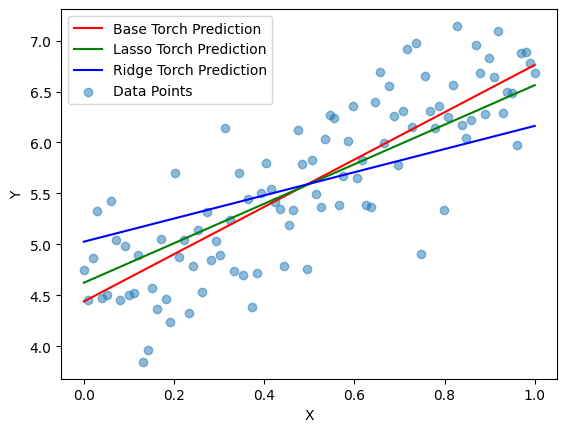

In [195]:
Y_pred_ols = model_torch.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_ols, color='red', label='Base Torch Prediction')

Y_pred_torch = model_torch_lasso.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_torch, color='green', label='Lasso Torch Prediction')

Y_pred_sklearn = model_torch_ridge.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_sklearn, color='blue', label='Ridge Torch Prediction')

plt.scatter(X, Y, label='Data Points', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

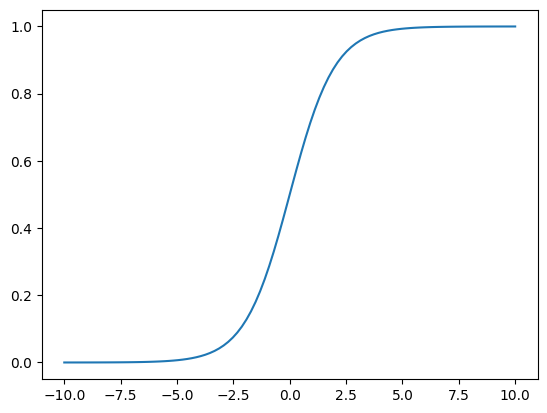

In [196]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)

In [197]:
class LogisticRegressionTorch:
    def __init__(self):
        self.model = None

    def fit(self, X, y, epochs=1000, lr=0.01):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        n_samples, n_features = X_tensor.shape
        self.model = torch.nn.Linear(n_features, 1)

        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        self.train(X_tensor, y_tensor, optimizer, criterion, epochs)

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_tensor)
            probabilities = torch.sigmoid(logits)
            return probabilities.numpy()
        return predictions.numpy()

In [198]:
path = kagglehub.dataset_download("yasserh/titanic-dataset")

df = pd.read_csv(path + '/Titanic-Dataset.csv')
df = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
df = df.dropna()
df['Sex'] = pd.get_dummies(df['Sex'], drop_first=True).astype(int)
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

In [199]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Survived']),
    df['Survived'],
    test_size=0.2,
    random_state=42
)

In [201]:
logistic_model = LogisticRegressionTorch()
logistic_model.fit(X_train.values, y_train.values, epochs=2000, lr=0.01)
y_pred_probs = logistic_model.predict(X_test.values)
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.88      0.19      0.31        80
           1       0.48      0.97      0.65        63

    accuracy                           0.53       143
   macro avg       0.68      0.58      0.48       143
weighted avg       0.71      0.53      0.46       143



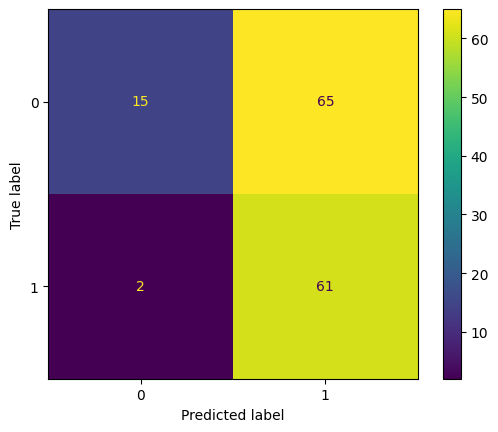

In [202]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()